# pyforeca: analyzing geo-spatial weather (temperature) time series data with ForeCA

This notebook is for demonstration purposes of how ForeCA works for analyzing and transforming time series data. We'll show in detail how ForeCA compares to other traditional dimension reduction techniques such as PCA, ICA, or SFA, and how ForeCA discovers new latent signals that the other ones miss.

See the `README` for details and references.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Not needed if in PATH
import os
import pathlib
parent_path = os.path.join(os.getcwd(), "..")

import sys
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

# Load relevant modules

In [3]:
import importlib
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import pyforeca
from pyforeca.datasets import reader
from pyforeca import viz
from pyforeca import spectral
from pyforeca import optimizer

In [5]:
# for Welch estimation
_NPERSEG = 256

# Load Average Monthly Temperature Data

This dataset contains average monthly temperature of 18 cities, spread across the northern and southern hemisphere.  See https://figshare.com/articles/dataset/temperature_csv/3171766?file=4938964 for details.

Obviously, the 2 main latent signals we should find from the data are yearly temperature cycle in the northern and southern hemisphere.

**tl;dr:** All 4 methods -- PCA, ICA, SFA, and ForeCA -- discover those latent signals.  ForeCA does identify them in the most smooth, clear way.  More interestingly, we'll see the major differences between the methods in  components 3, 4, ...are.

## Load & process data

In [6]:
df = reader.request_temperature_data()

We need to process the raw data for some standard data cleaning, processing, filtering, and forward filling to guarantee 0 missingness across all 18 time series.

In [7]:
_TAIL = 12 * 10  # 10 years -- used for plotting/inspection of time series patterns in graphs
df_wide_cels = reader.process_temperature_data(df.copy(), to_celsius=True)
df_wide_cels

city        Auckland  Brasília  Canoas  Cape Town  Hamilton  Johannesburg  \
1859-10-01    14.064    22.739  17.806     14.861    13.392        16.546   
1859-11-01    14.775    21.873  19.646     16.415    14.293        17.559   
1859-12-01    16.342    21.186  21.888     17.981    16.109        18.341   
1860-01-01    18.466    21.959  23.407     19.448    18.268        19.171   
1860-02-01    18.780    21.838  22.736     19.373    18.329        18.752   
...              ...       ...     ...        ...       ...           ...   
2013-05-01    15.278    22.369  15.562     15.473    12.771        12.154   
2013-06-01    13.450    21.784  13.770     12.841    12.771         9.982   
2013-07-01    12.345    21.204  12.808     13.526     9.630         9.755   
2013-08-01    13.758    22.405  13.071     12.374    11.582        12.214   
2013-09-01    13.758    22.405  13.071     12.374    11.582        12.214   

city        Kherson    Kiev    Lvov  Marseille   Odesa   Paris  Stockholm  \
1859-10-01    9.935   8.101   8.617     18.175  12.896  12.054      7.416   
1859-11-01    2.350   1.049   1.876     13.042   6.839   5.476      4.578   
1859-12-01   -0.298  -3.747  -4.451      8.107   4.922   1.070     -0.415   
1860-01-01   -1.486  -3.648  -2.068     10.449   3.053   4.722      0.132   
1860-02-01   -1.947  -4.782  -3.895      6.715   1.292   1.024     -4.294   
...             ...     ...     ...        ...     ...     ...        ...   
2013-05-01   19.732  19.000  16.129     15.330  18.000  11.703     10.746   
2013-06-01   22.232  21.222  18.893     19.582  20.603  16.340     14.308   
2013-07-01   22.472  20.483  19.158     24.093  21.840  21.186     17.020   
2013-08-01   22.861  19.944  19.168     23.993  23.237  19.235     16.924   
2013-09-01   22.861  19.944  19.168     23.993  23.237  19.235     16.924   

city         Tokyo  Tottori  Uppsala  Warsaw  Wroclaw  
1859-10-01  13.584   15.991    3.539   8.311    8.810  
1859-11-01   8.207   10.460   -0.260   2.225    2.207  
1859-12-01   4.048    5.929   -5.744  -4.870   -4.192  
1860-01-01   0.032    2.632   -5.198  -1.894   -0.427  
1860-02-01   1.172    3.595   -8.947  -3.915   -3.148  
...            ...      ...      ...     ...      ...  
2013-05-01  16.757   18.422   12.114  15.643   12.808  
2013-06-01  20.927   22.773   14.896  18.394   16.204  
2013-07-01  24.645   27.596   16.788  19.638   19.317  
2013-08-01  26.364   28.529   15.091  19.278   18.092  
2013-09-01  26.364   28.529   15.091  19.278   18.092  

[1848 rows x 18 columns]

## Basic data exploration

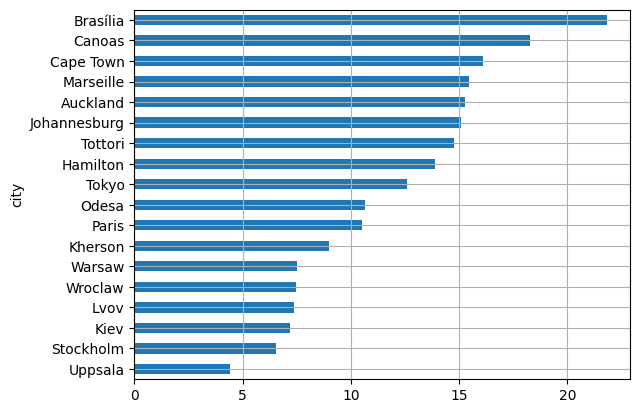

In [8]:
df_wide_cels.mean().sort_values().plot.barh()
plt.grid()

Let's look at last 10 years of data for coldest (Uppsala) and warmest (Brasilia) city in the dataset.

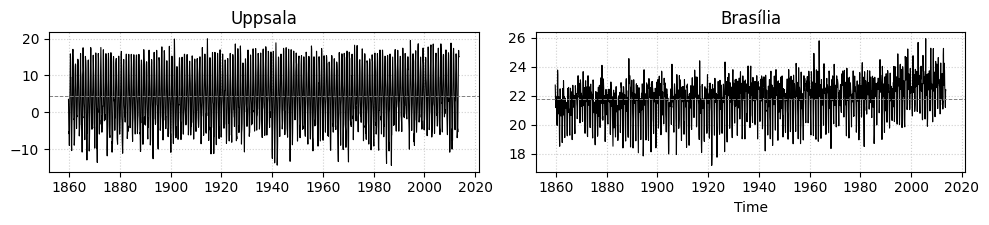

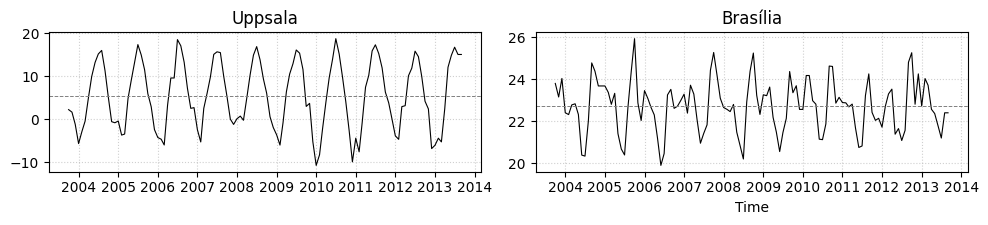

In [9]:
_ = viz.plot_time_series(df_wide_cels[["Uppsala", "Brasília"]], n_cols=2)
plt.show()
_ = viz.plot_time_series(df_wide_cels[["Uppsala", "Brasília"]].tail(_TAIL), n_cols=2)

## Prepare for dimension reduction and comparability

Scale data to zero-mean/unit-variance for better interpretation of loadings/weights downstream. Also by scaling we get better sense of patterns in norther vs southern hemisphere, w/o being dominated by temperature shifts within the same hemisphere.  See below.

In [10]:
df_wide = reader.process_temperature_data(df.copy(), to_celsius=True, zero_mean_unit_variance=True)

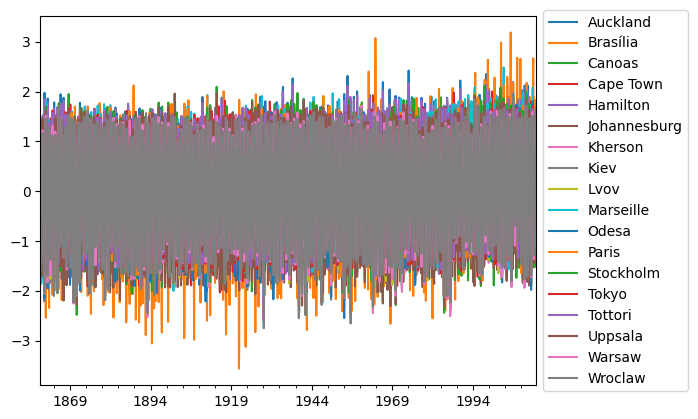

In [11]:
df_wide.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

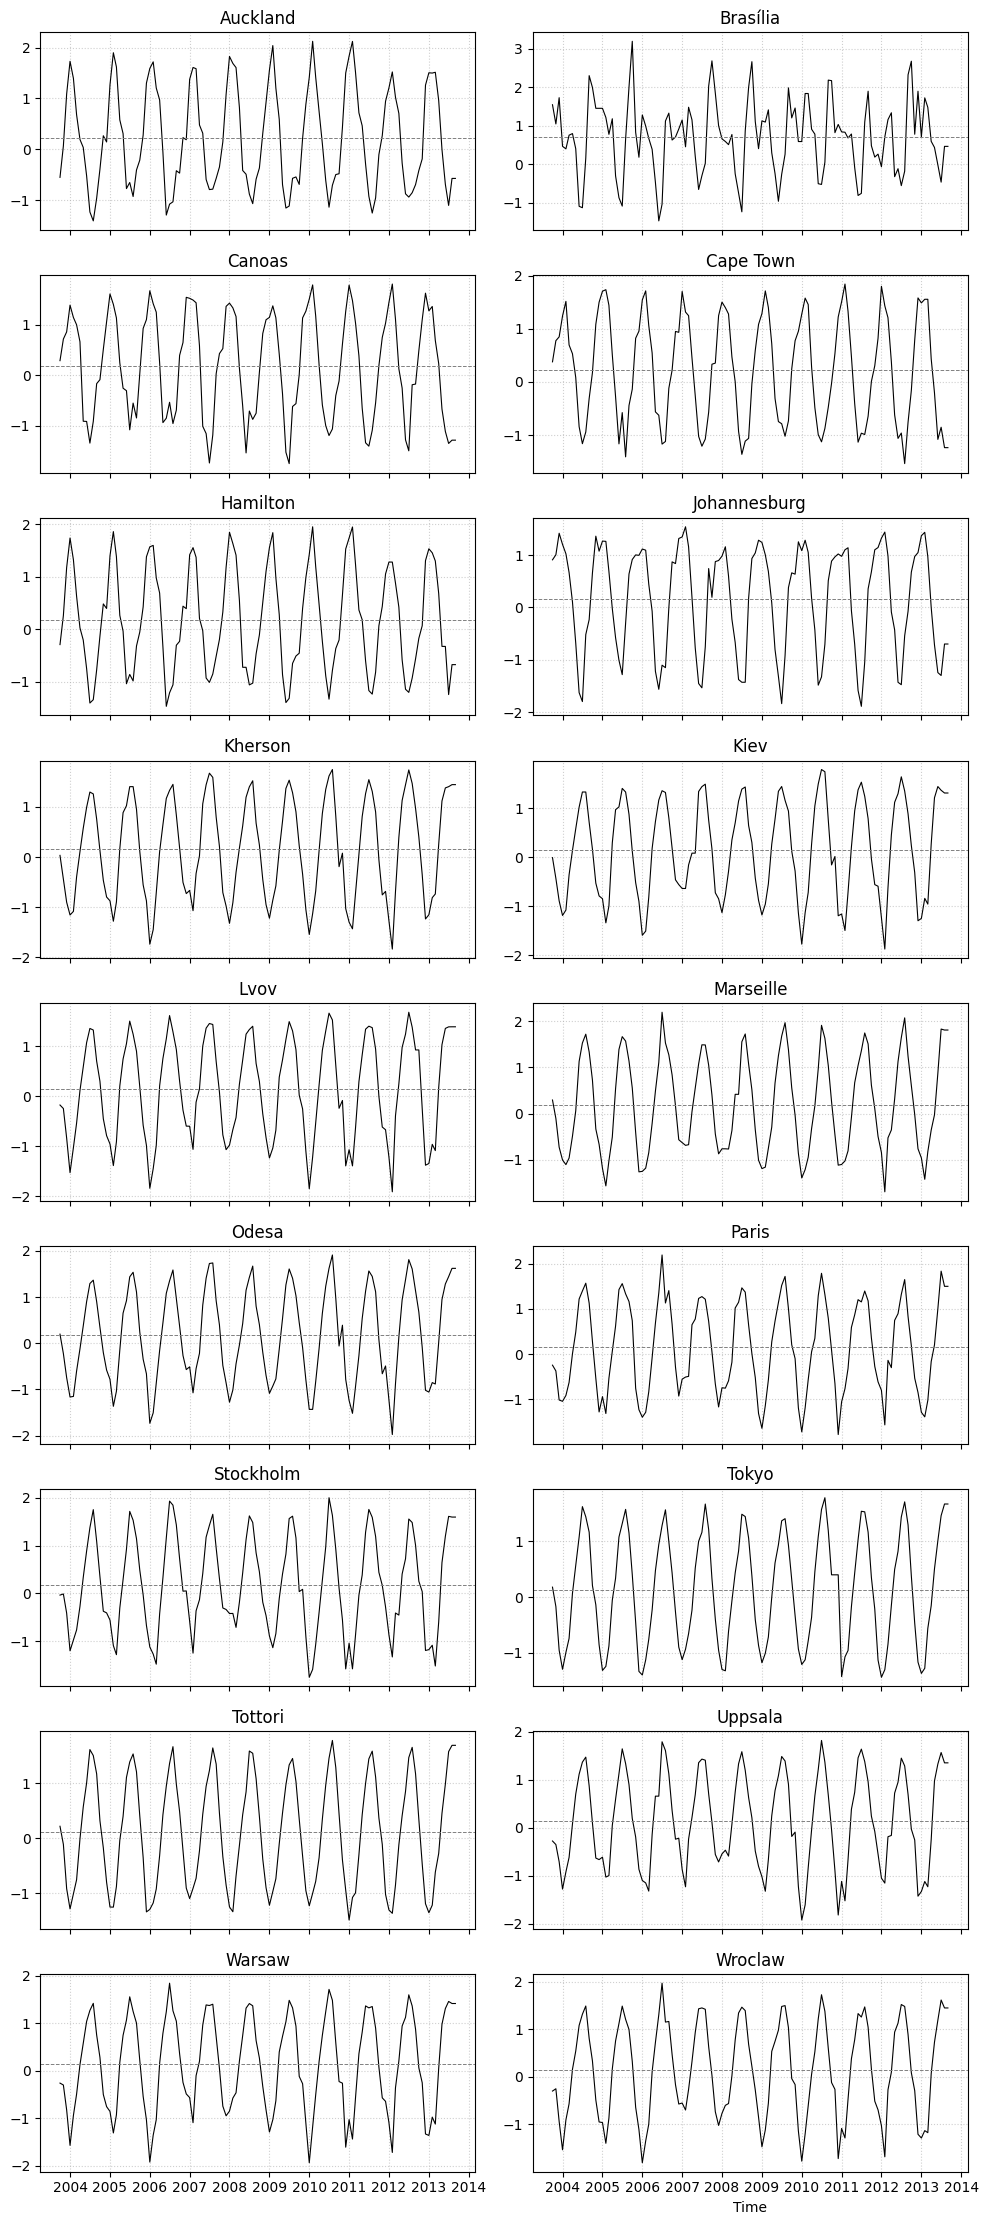

In [12]:
_ = viz.plot_time_series(df_wide.tail(_TAIL), n_cols=2)

<Axes: xlabel='city', ylabel='city'>

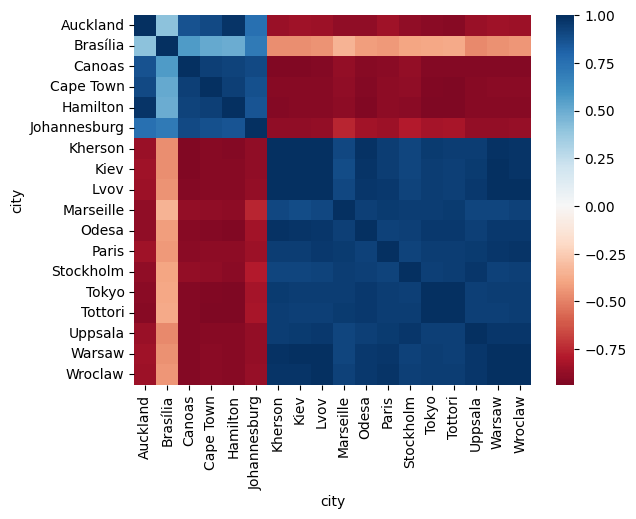

In [13]:
sns.heatmap(df_wide.corr(), cmap="RdBu", center=0.)

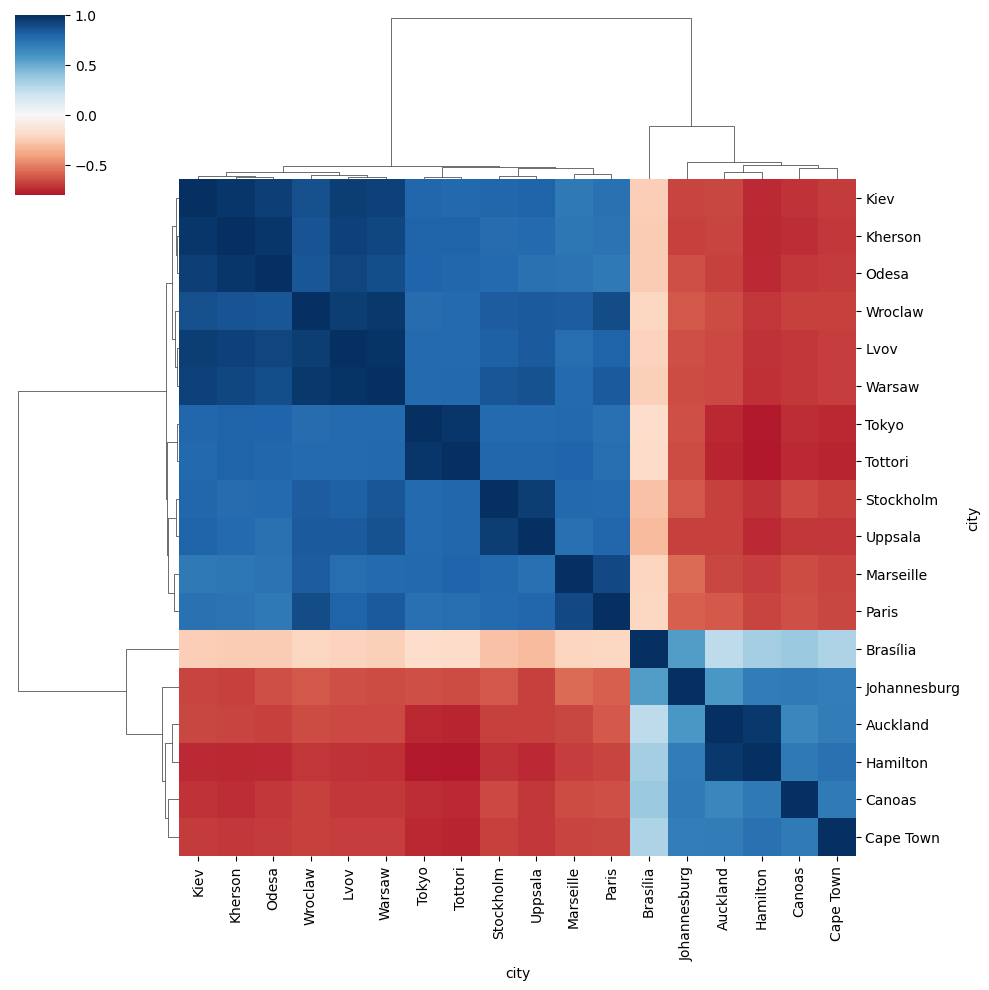

In [14]:
sns.clustermap(df_wide.diff().corr(), cmap="RdBu", center=0.)

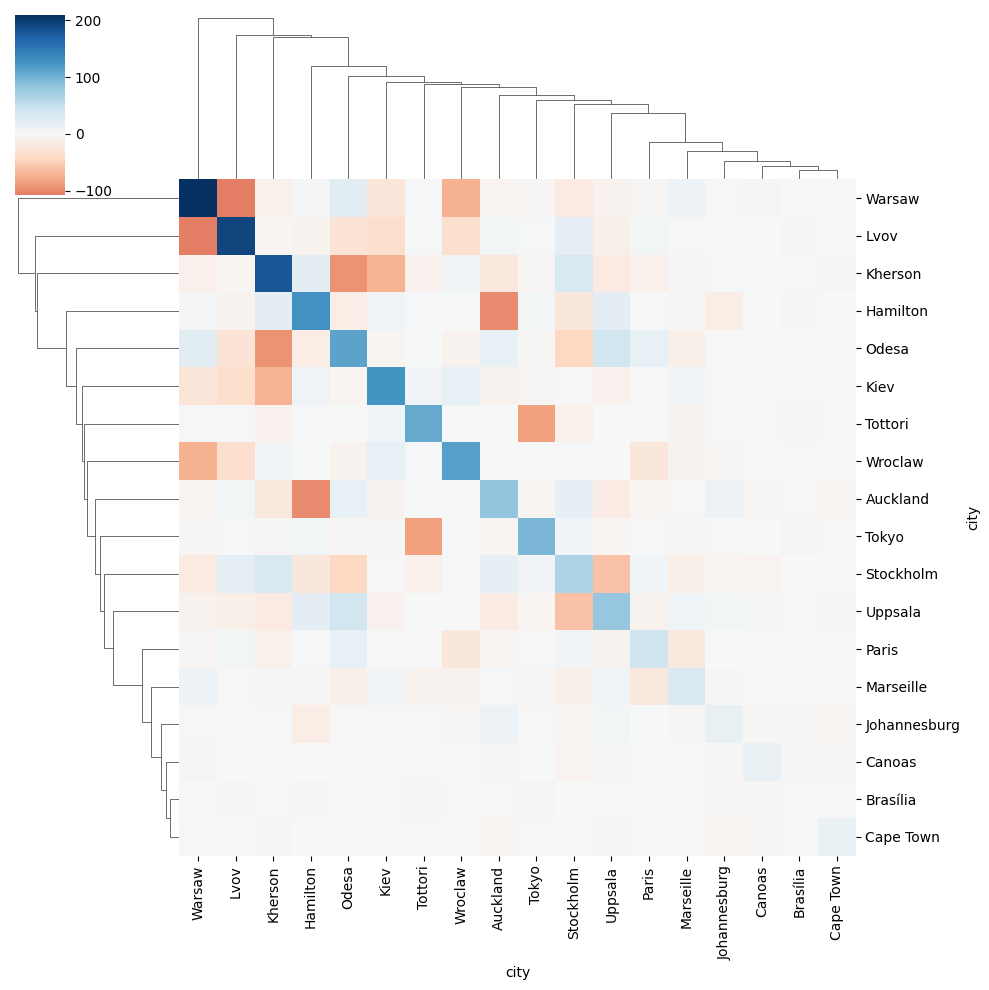

In [15]:
importlib.reload(pyforeca.utils)
sns.clustermap(pyforeca.utils.partial_cov(df_wide), cmap="RdBu", center=0.)

In [16]:
avg_tmp_ns = pd.concat({k: v.mean(axis=1) for k, v in reader.split_by_hemisphere(df_wide).items()}, axis=1)
avg_tmp_ns

north     south
1859-10-01  0.169671 -0.007360
1859-11-01 -0.596546  0.173038
1859-12-01 -1.248106  0.482400
1860-01-01 -1.149531  0.998048
1860-02-01 -1.445432  0.956121
...              ...       ...
2013-05-01  0.730684 -0.246952
2013-06-01  1.196245 -0.745667
2013-07-01  1.546790 -1.053147
2013-08-01  1.521150 -0.667973
2013-09-01  1.521150 -0.667973

[1848 rows x 2 columns]

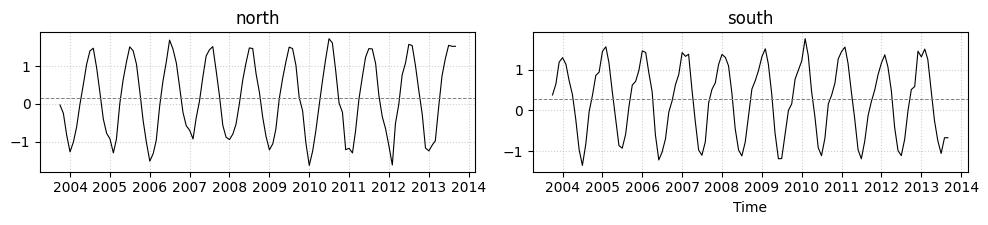

In [61]:
_ = viz.plot_time_series(avg_tmp_ns.tail(_TAIL), n_cols=2)

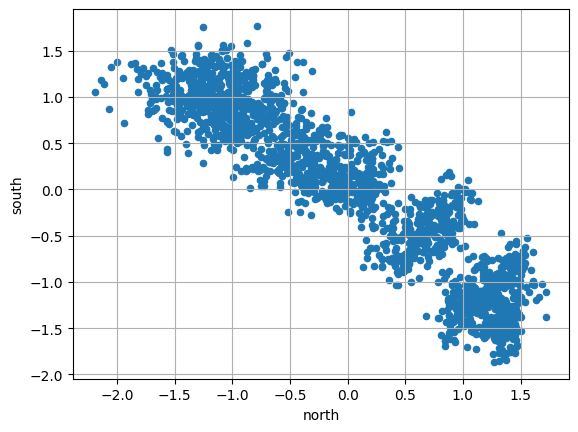

In [18]:
avg_tmp_ns.plot.scatter("north", "south")
plt.grid()

# Compare dimension reduction technique results

## PCA vs ICA vs ForeCA

Here we compare ForeCA to 3 standard dimension reduction techniques:

* PCA
* ICA
* SFA


## PCA: find highest variance signals

In [19]:
mod_pca = sklearn.decomposition.PCA(whiten=True)
mod_pca.fit(df_wide)

PCA(whiten=True)

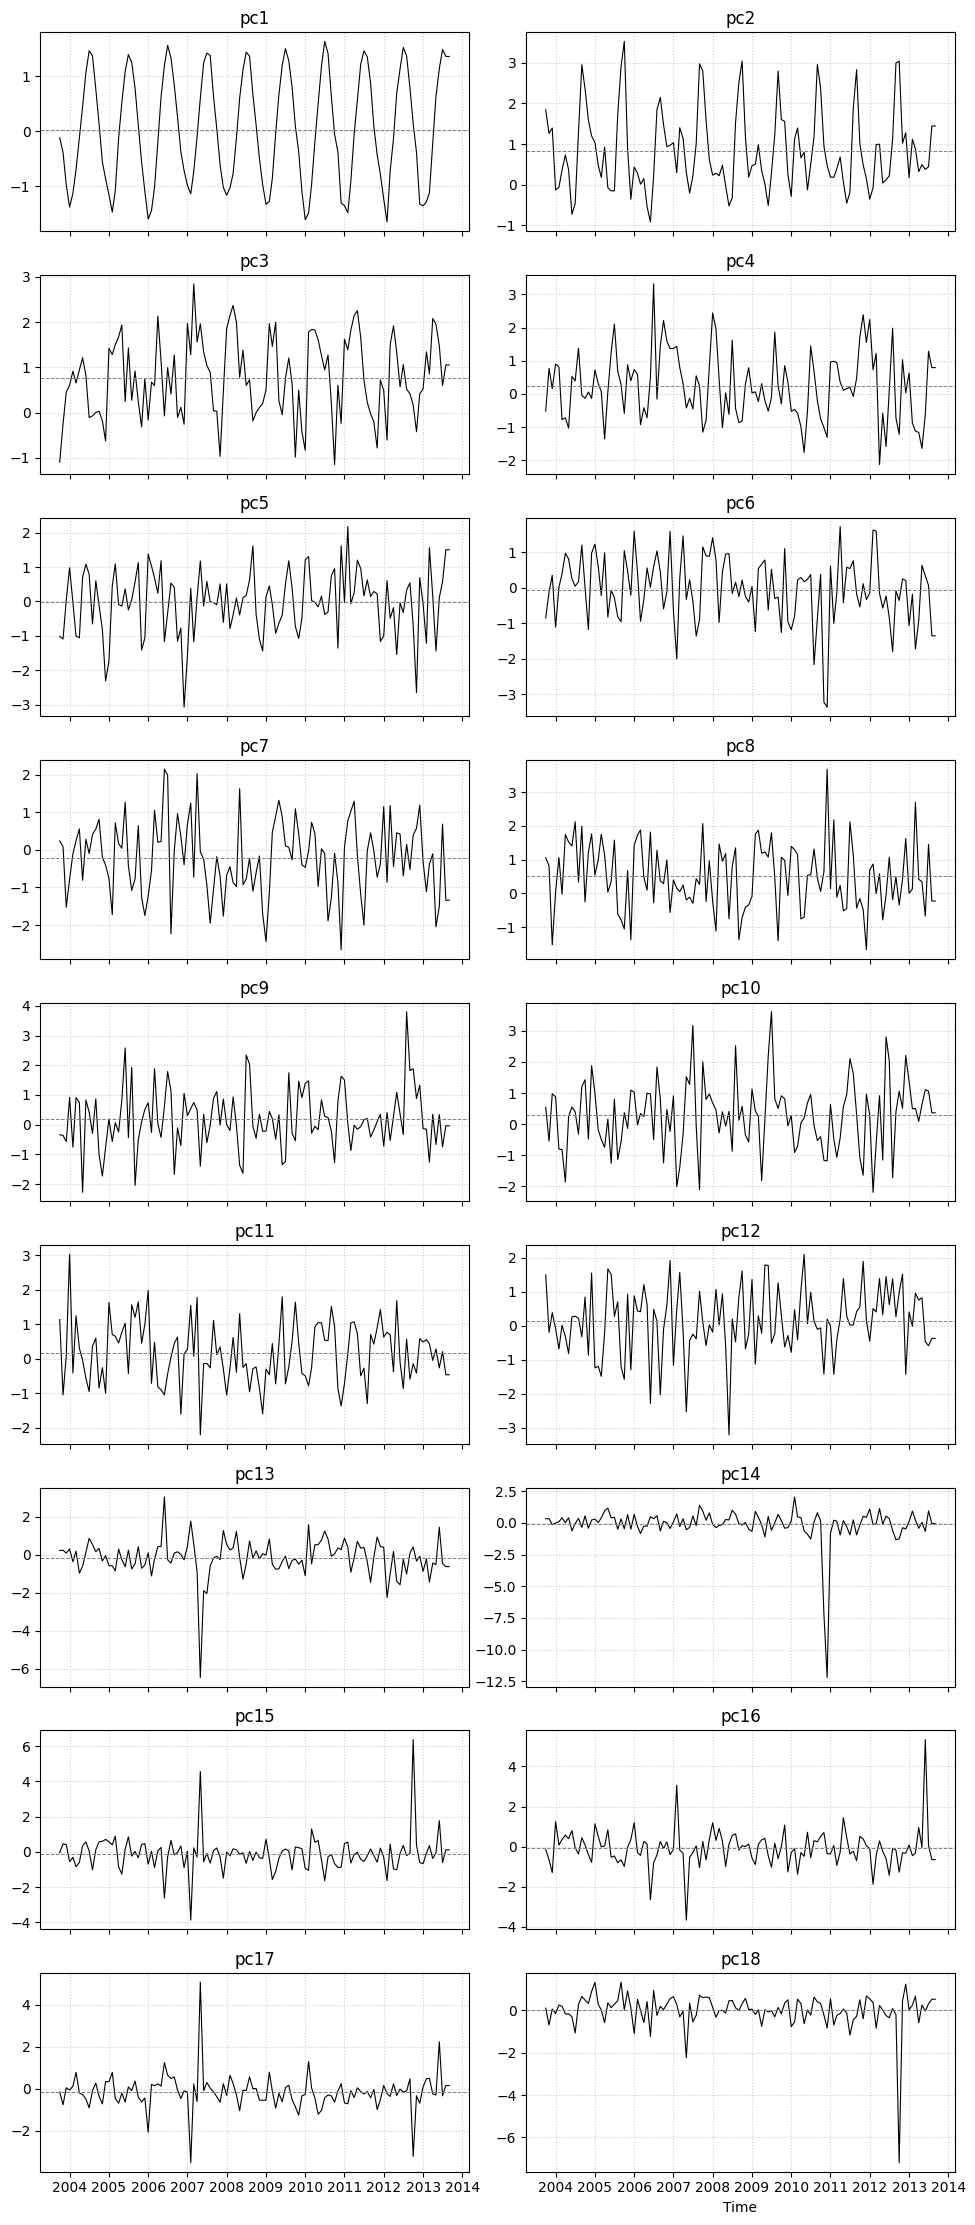

In [20]:
pcs = pd.DataFrame(mod_pca.transform(df_wide), index=df_wide.index, 
                   columns=["pc" + str(k + 1) for k in range(df_wide.shape[1])])
_ = viz.plot_time_series(pcs.tail(_TAIL), n_cols=2)

<Axes: >

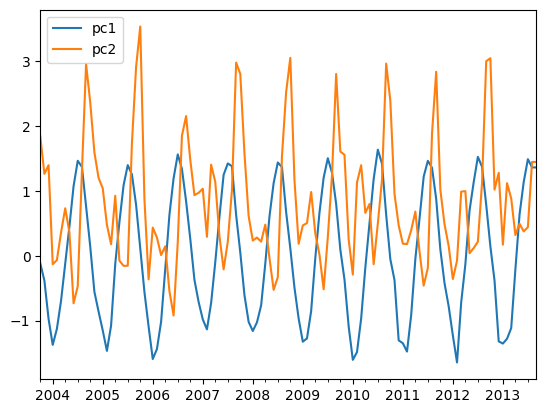

In [21]:
pcs.iloc[:, 0:2].tail(_TAIL).plot()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


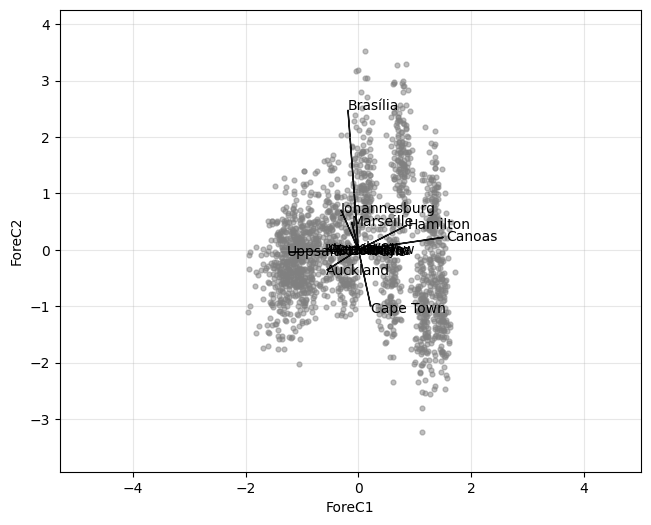

In [22]:
_ = viz.biplot(mod_pca, df_wide, comps=(0, 1))

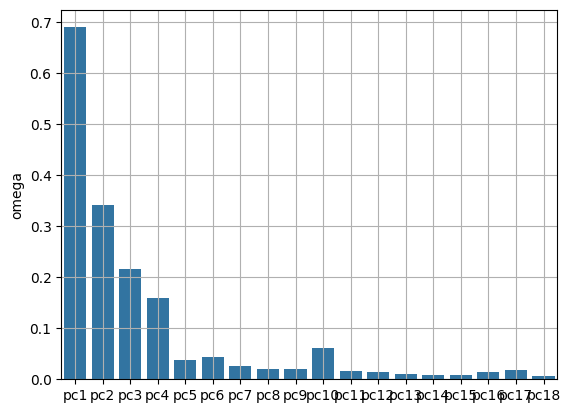

In [23]:
pc_omegas = spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(pcs).mvspectrum_.omegas()
sns.barplot(pc_omegas)
plt.grid()

## SFA: slow feature analysis

See https://www.cnbc.cmu.edu/~tai/readings/learning/wiskott_sejnowski_2002.pdf for details.

In [24]:
import pyforeca.sfa
mod_sfa = pyforeca.sfa.SFA()
mod_sfa.fit(df_wide)

SFA()

<Axes: >

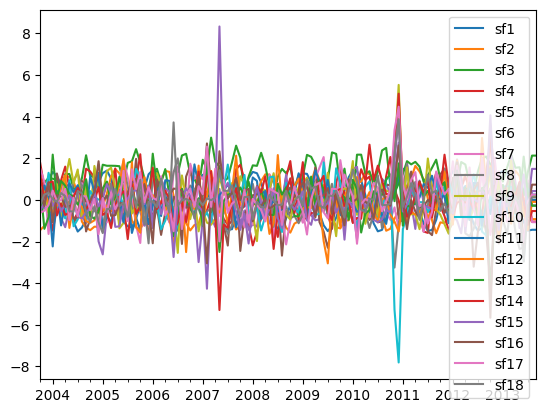

In [25]:
sfs = pd.DataFrame(mod_sfa.transform(df_wide), index=df_wide.index, 
                   columns=["sf" + str(k + 1) for k in range(df_wide.shape[1])])
sfs.tail(_TAIL).plot()

<Axes: >

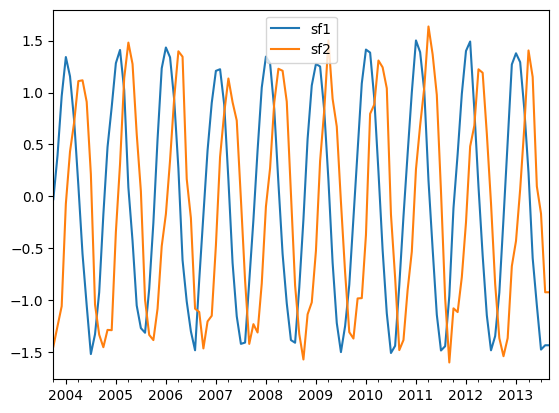

In [26]:
sfs.iloc[:, 0:2].tail(_TAIL).plot()

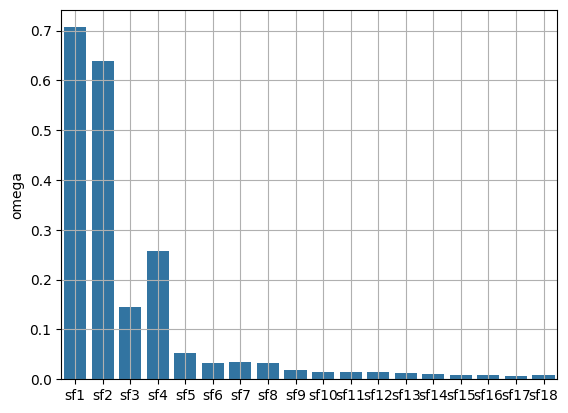

In [27]:
sf_omegas = spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(sfs).mvspectrum_.omegas()
sns.barplot(sf_omegas)
plt.grid()

## ICA: find independent signals

See https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html and reference therein.

In [28]:
mod_ica = sklearn.decomposition.FastICA(n_components=df_wide.shape[1], random_state=42)
mod_ica.fit(df_wide)

FastICA(n_components=18, random_state=42)

<Axes: >

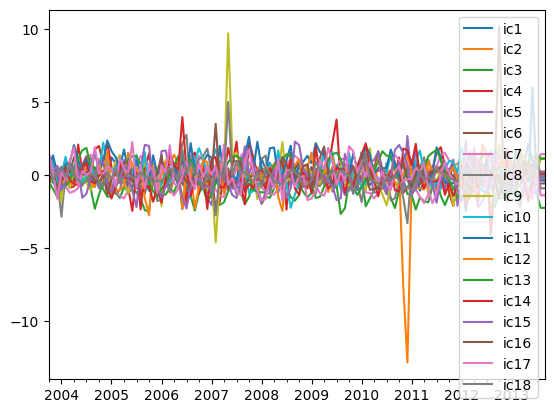

In [29]:
ics = pd.DataFrame(mod_ica.transform(df_wide), index=df_wide.index, 
                   columns=["ic" + str(k + 1) for k in range(df_wide.shape[1])])
ics.tail(_TAIL).plot()

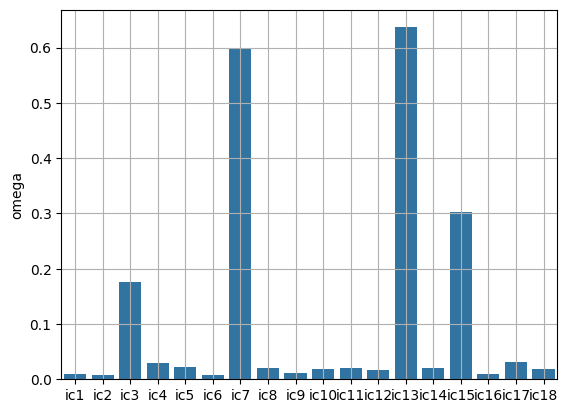

In [30]:
# order them by omega
ic_omegas = spectral.MVSpectrumEstimator(nperseg=_NPERSEG).fit(ics).mvspectrum_.omegas()
sns.barplot(ic_omegas)
plt.grid()

ic1     12
ic2      6
ic3     14
ic4      2
ic5     16
ic6      3
ic7      4
ic8      7
ic9     13
ic10    10
ic11    17
ic12     9
ic13    11
ic14     8
ic15     0
ic16    15
ic17     5
ic18     1
Name: omega, dtype: int64


<Axes: >

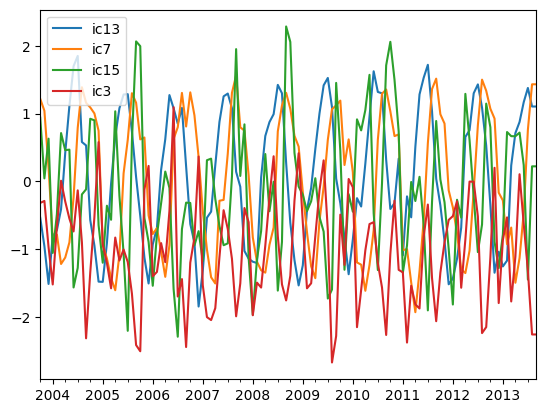

In [31]:
ics_sorted_ids = np.argsort(-ic_omegas)
print(ics_sorted_ids)
ics.iloc[:, ics_sorted_ids].iloc[:, :4].tail(_TAIL).plot()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


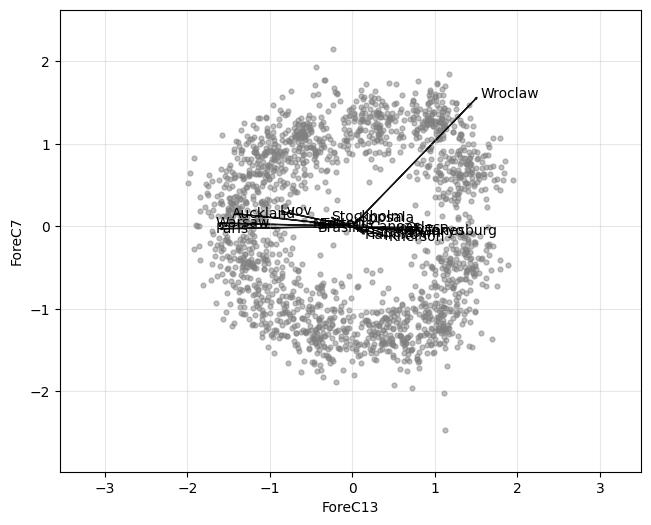

In [32]:
_ = viz.biplot(mod_ica, df_wide, comps=ics_sorted_ids[:2])

<Axes: >

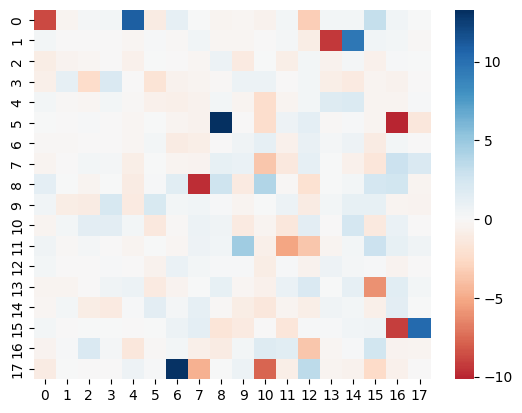

In [33]:
sns.heatmap(mod_ica.components_, cmap="RdBu", center=0.)

## ForeCA: find most forecastable signals

Here we use ForeCA to find more interesting signals and latent seasonal weather / climate patterns in the data.

Obviously, the 2 main signal we should find at the top are the norther and southern yearly cycle.

Beyond the 

In [34]:
mvspec_est = pyforeca.spectral.MVSpectrumEstimator()
mvspec_est.fit(X=df_wide)

MVSpectrumEstimator(nperseg=184)

<Axes: xlabel='frequency', ylabel='PSD'>

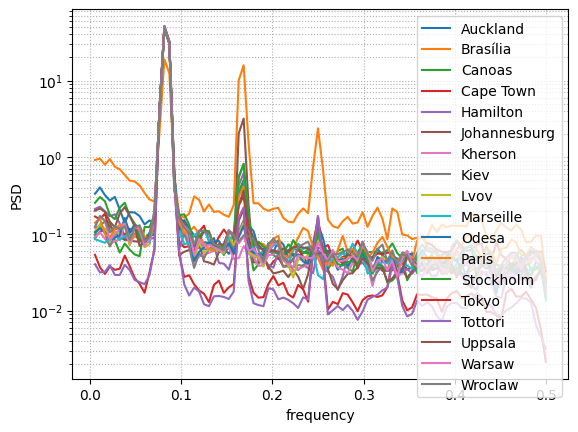

In [35]:
mvspec_est.mvspectrum_.plot()

In [51]:
mod_foreca = pyforeca.base.ForeCA(n_components=8, nperseg=_NPERSEG, init_method=optimizer.InitMethod.SFA)
mod_foreca.fit(df_wide)

Finding ForeC 8 ...


ForeCA(init_method=<InitMethod.SFA: 'sfa'>, n_components=8, nperseg=256)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


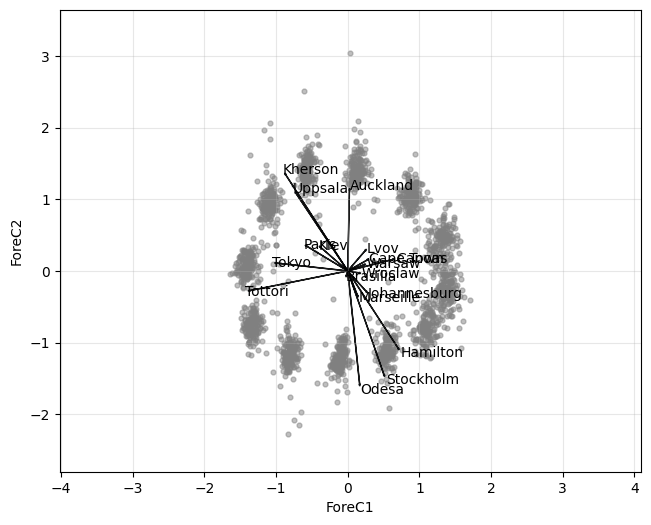

In [52]:
_ = viz.biplot(mod_foreca, df_wide, comps=(0, 1))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


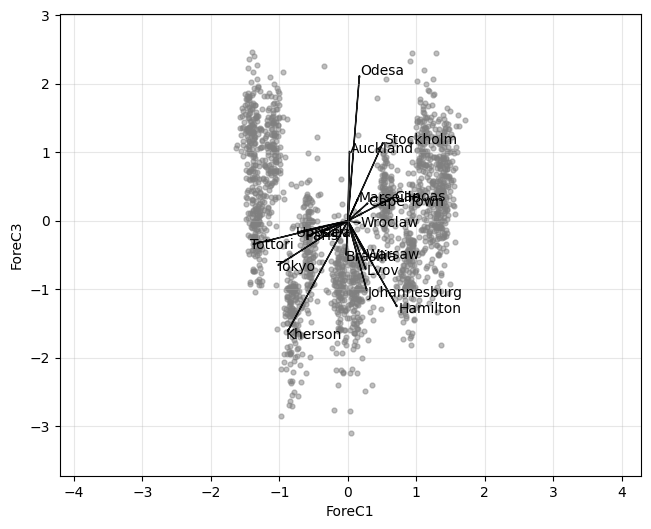

In [53]:
_ = viz.biplot(mod_foreca, df_wide, comps=(0, 2))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


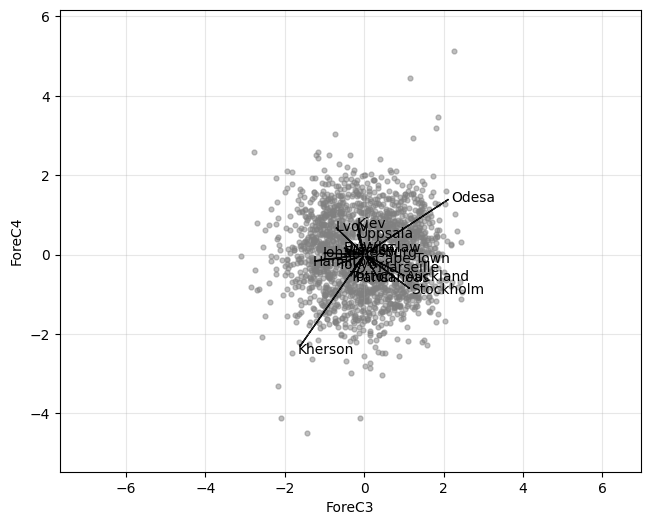

In [54]:
_ = viz.biplot(mod_foreca, df_wide, comps=(2, 3))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


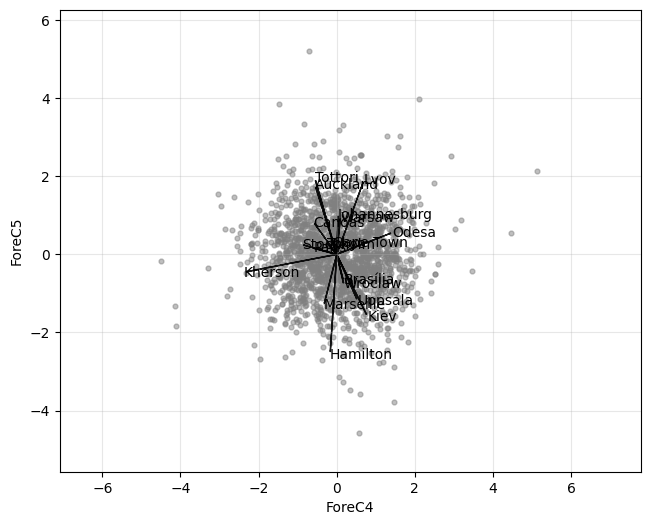

In [55]:
_ = viz.biplot(mod_foreca, df_wide, comps=(3, 4))

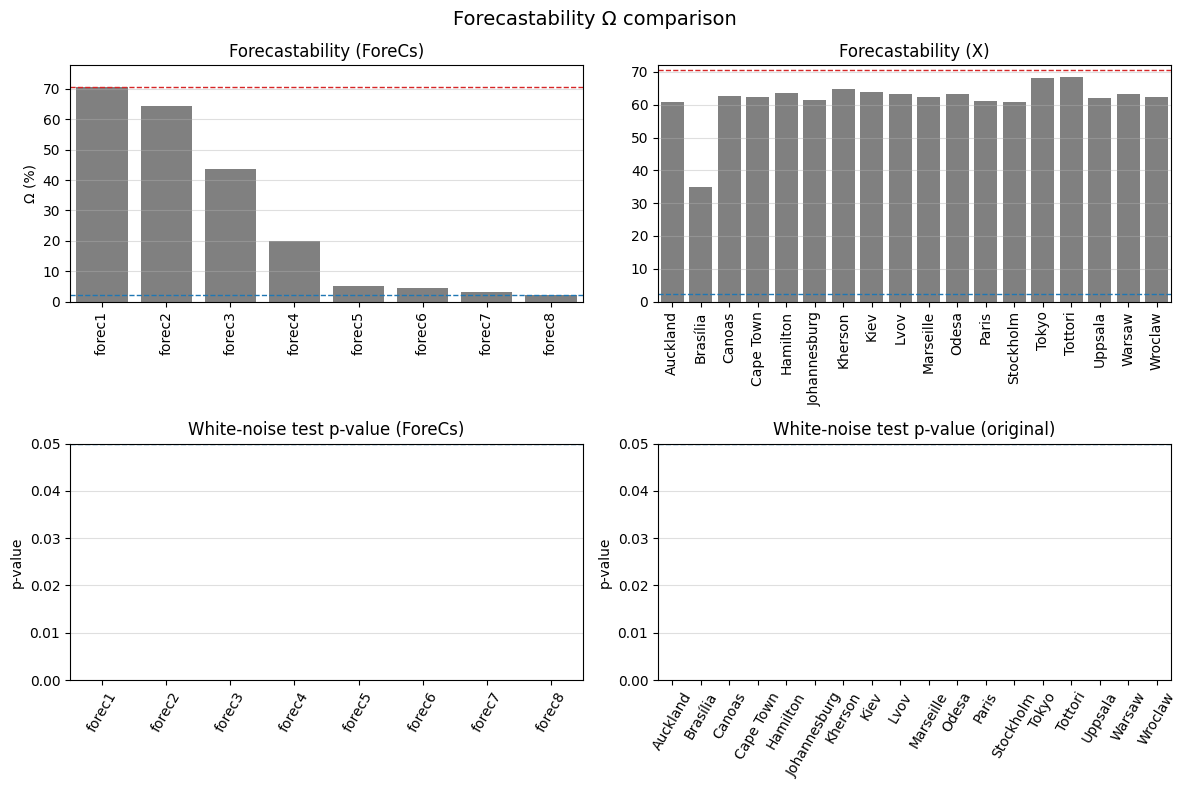

In [56]:
_ = viz.plot_foreca(mod_foreca, X=df_wide, add_white_noise_test=True)

In [57]:
fcs = mod_foreca.transform(df_wide)
fcs

forec1    forec2    forec3    forec4    forec5    forec6  \
1859-10-01 -0.087190 -1.213292 -0.776787  0.542317 -1.137231  0.817213   
1859-11-01  0.532810 -1.197604  0.475240  1.487412  0.001430  0.129823   
1859-12-01  1.006822 -0.834887  1.445650  1.141634  1.026712  0.078279   
1860-01-01  1.379323 -0.262030  1.048901 -0.104711 -0.588602 -0.174494   
1860-02-01  1.322120  0.485189  0.099508  0.569645  1.323439  0.808534   
...              ...       ...       ...       ...       ...       ...   
2013-05-01 -0.614664  1.213318 -0.617281  1.071031 -0.407967 -0.990602   
2013-06-01 -1.047065 -0.004950 -0.935767  0.171893 -3.271095 -0.041501   
2013-07-01 -1.462920 -0.158312  0.444691 -1.439977 -0.603882 -0.487430   
2013-08-01 -1.379000 -0.987639 -0.728393 -1.704857 -0.337038  1.453663   
2013-09-01 -1.379000 -0.987639 -0.728393 -1.704857 -0.337038  1.453663   

              forec7    forec8  
1859-10-01 -0.558198  0.719188  
1859-11-01 -0.001964 -0.312383  
1859-12-01  0.479049 -0.104167  
1860-01-01  0.363967  1.106491  
1860-02-01  0.644020 -0.120840  
...              ...       ...  
2013-05-01  1.922310  1.333757  
2013-06-01  2.275060  0.342904  
2013-07-01 -0.121117  0.009135  
2013-08-01  1.475253  0.565103  
2013-09-01  1.475253  0.565103  

[1848 rows x 8 columns]

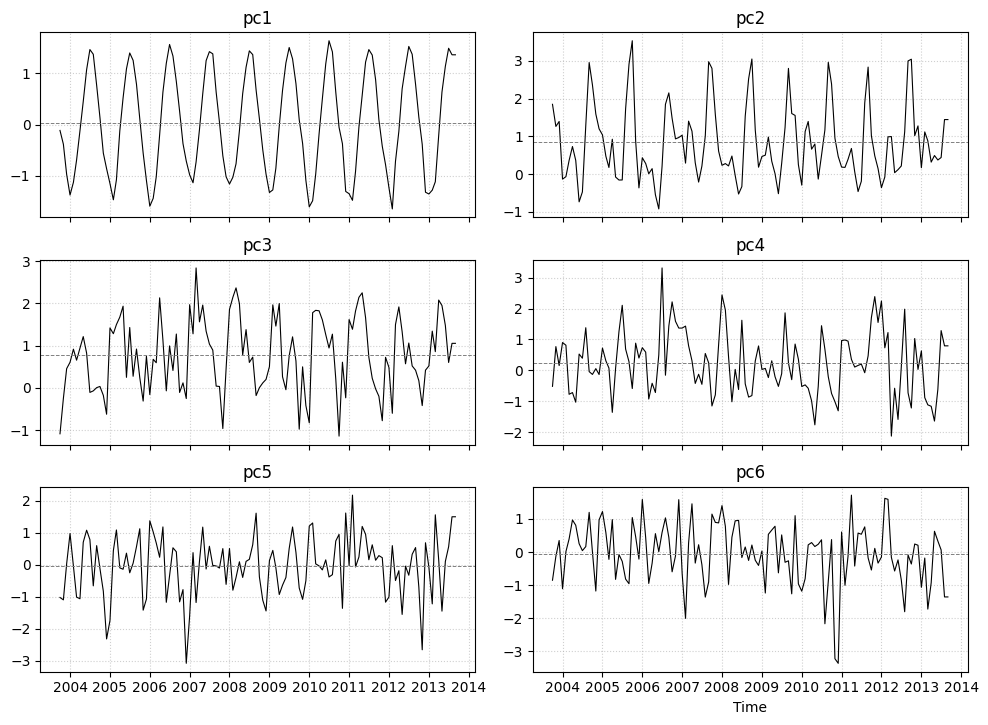

In [58]:
_ = viz.plot_time_series(pcs.iloc[:, :6].tail(_TAIL), n_cols=2)

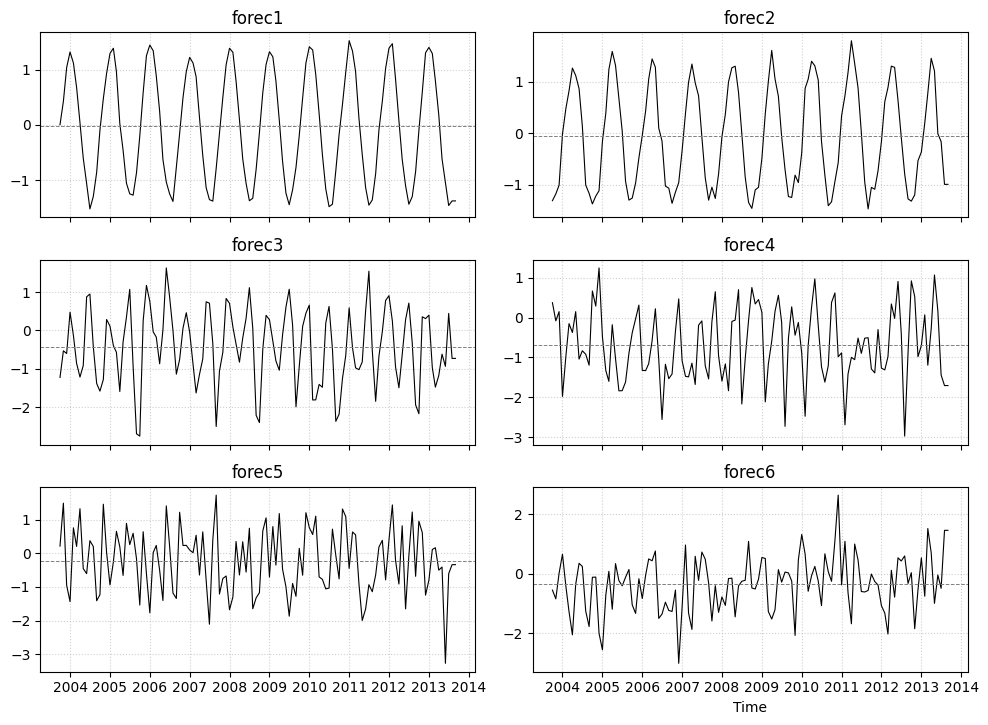

In [44]:
_ = viz.plot_time_series(fcs.iloc[:, :6].tail(_TAIL), n_cols=2)

<Axes: ylabel='city'>

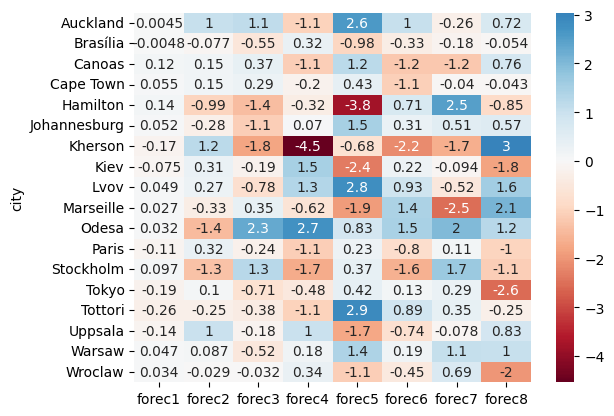

In [60]:
sns.heatmap(mod_foreca.components_, annot=True, cmap="RdBu", center=0.)

In [47]:
mv_est = pyforeca.spectral.MVSpectrumEstimator(nperseg=_NPERSEG)
mv_est.fit(X=fcs)

MVSpectrumEstimator(nperseg=256)

<Axes: xlabel='frequency', ylabel='PSD'>

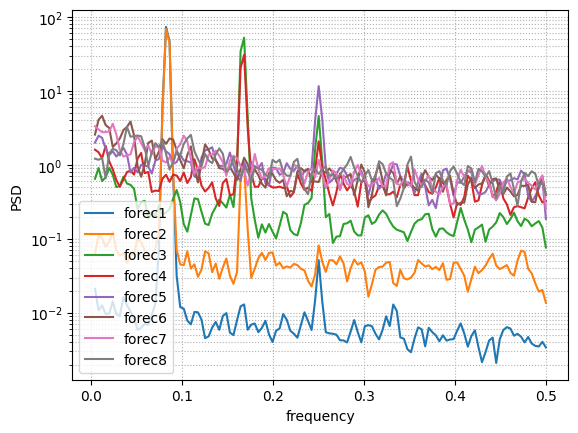

In [48]:
mv_est.mvspectrum_.normalize_whiten().plot()

## Review loadings and spectra per component

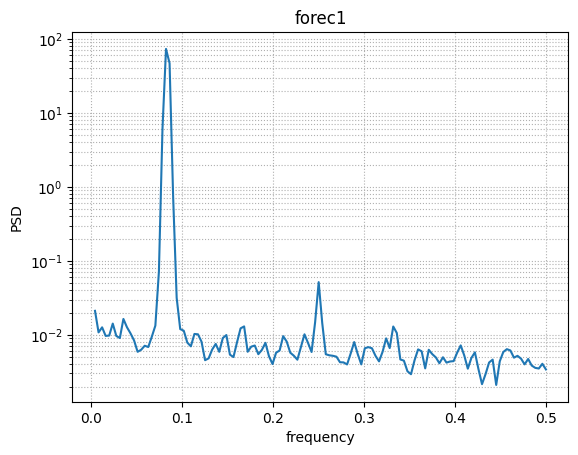

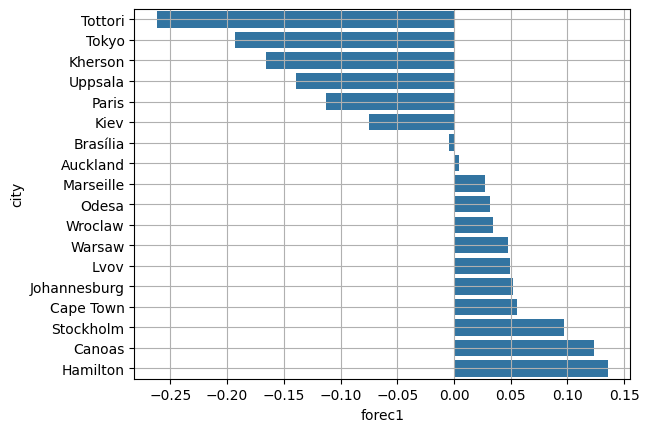

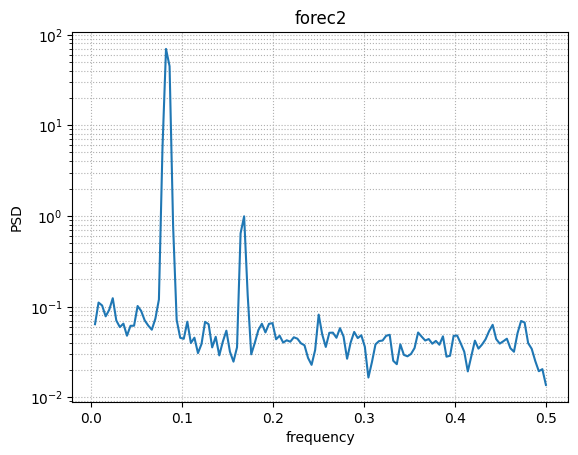

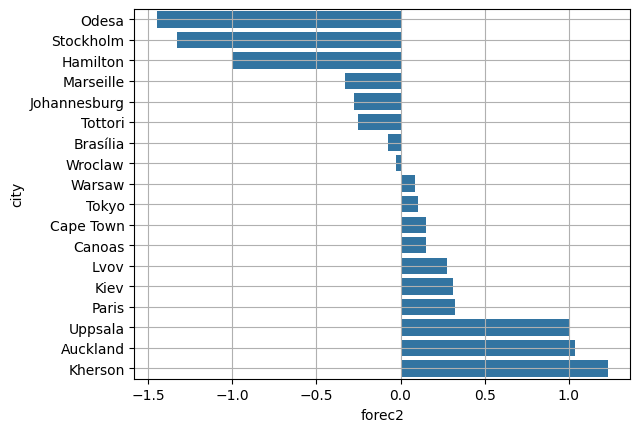

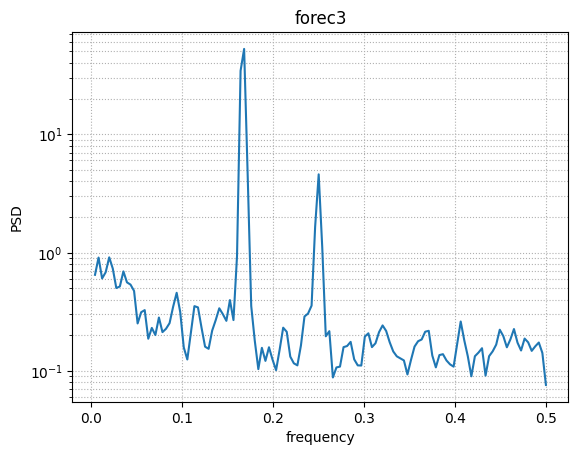

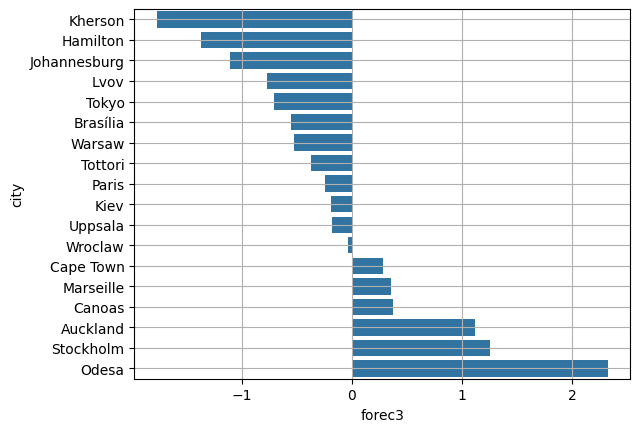

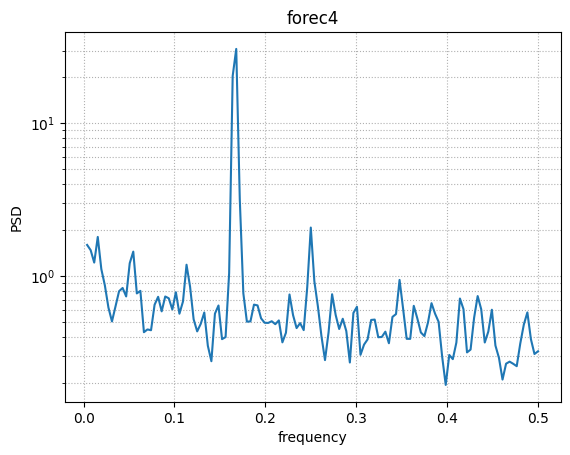

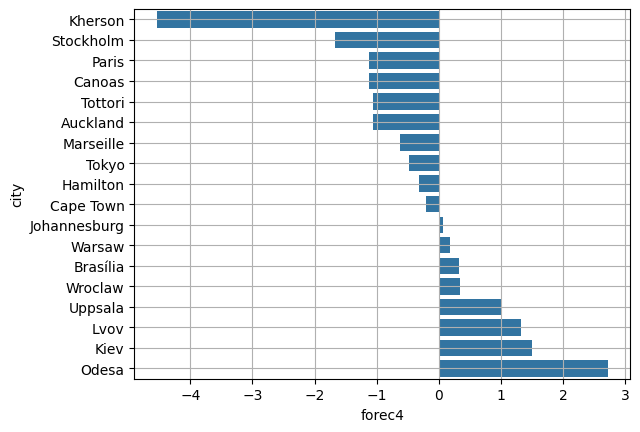

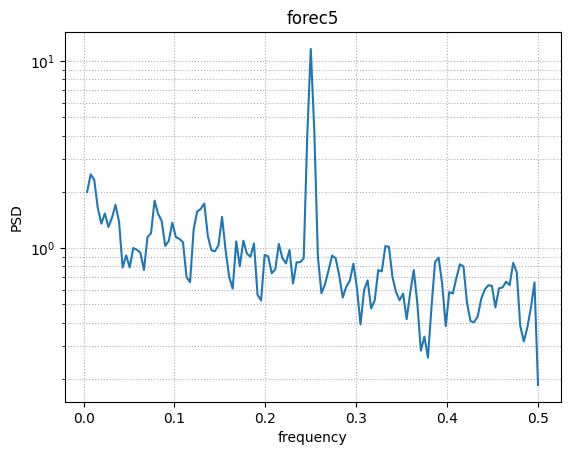

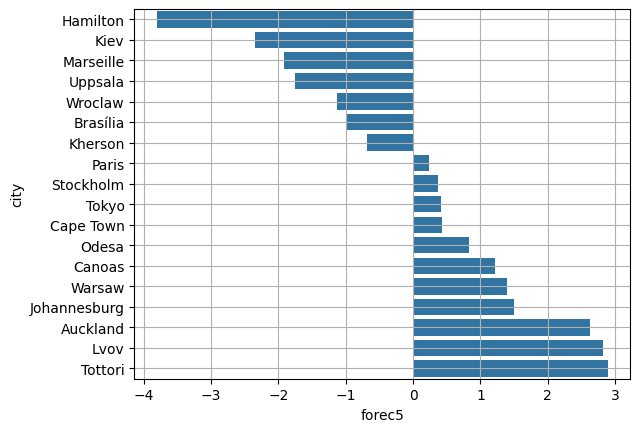

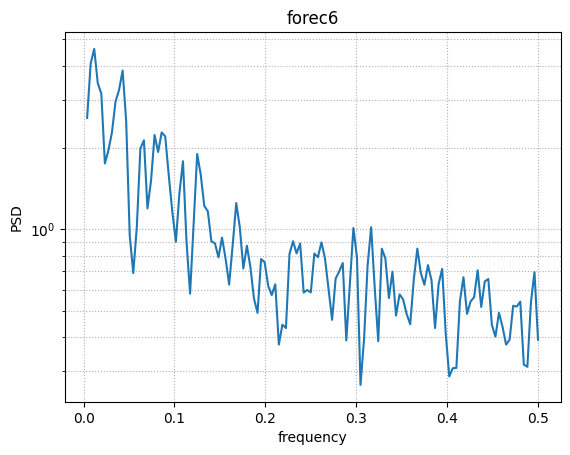

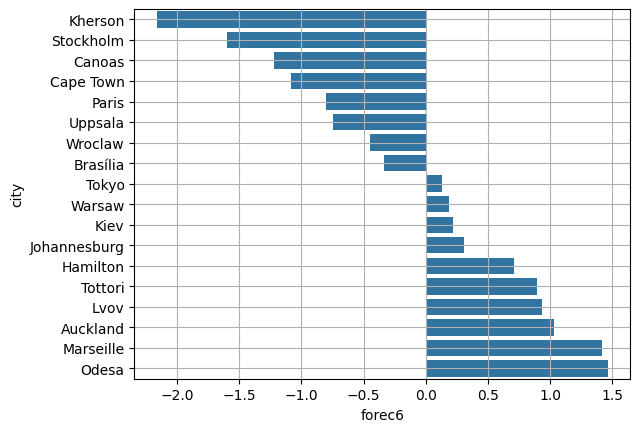

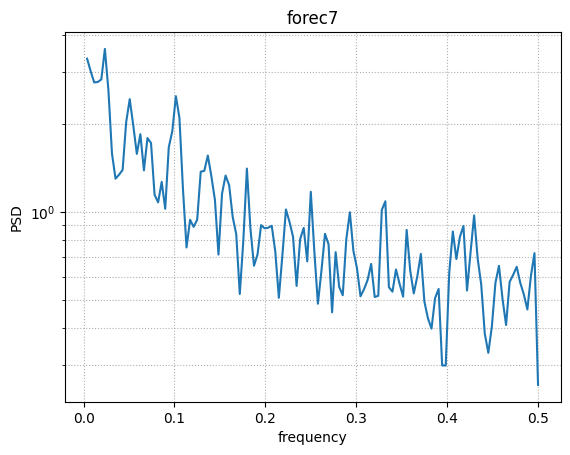

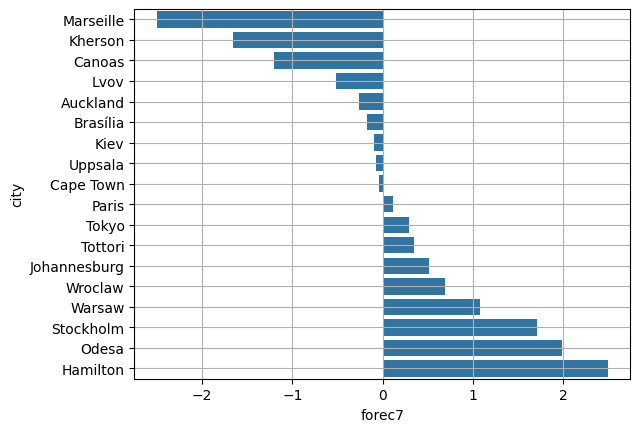

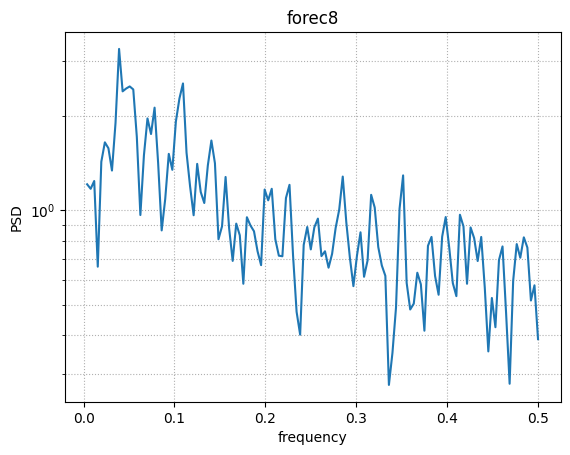

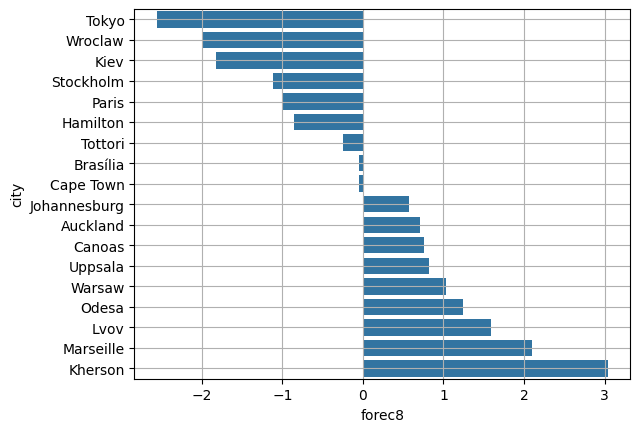

In [49]:
for i in range(mod_foreca.n_components):
    mv_est.mvspectrum_.normalize_whiten().get_univariate(i).plot()
    plt.show()
    comp_loadings = mod_foreca.components_.iloc[:, i]
    sns.barplot(data=comp_loadings.to_frame().sort_values(comp_loadings.name), y="city", x=comp_loadings.name)
    plt.grid()
    plt.show()

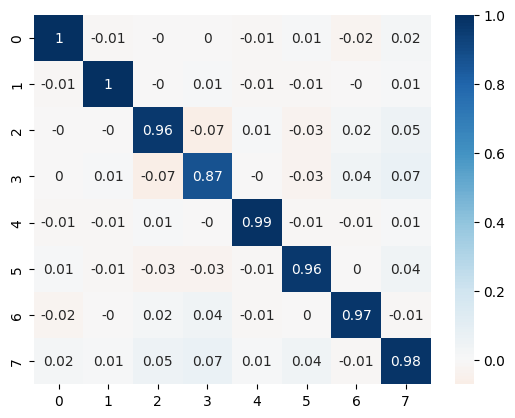

<Axes: >

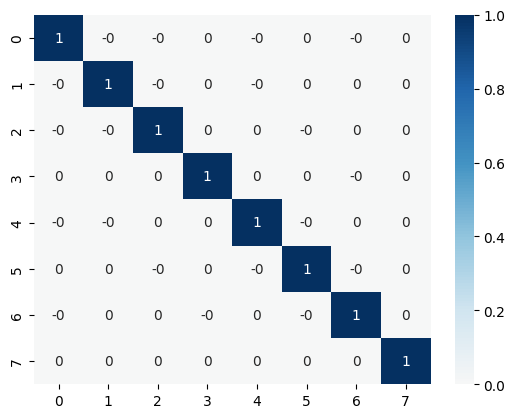

In [50]:
sns.heatmap(mv_est.mvspectrum_.wcov().round(2), cmap="RdBu", center=0., annot=True)
plt.show()
sns.heatmap(mv_est.mvspectrum_.normalize_whiten().wcov().round(2), cmap="RdBu", center=0., annot=True)